#Trabajo final Data Science III
#Pierre Cabot
#Parte 1


#1) Introducción

**Descripción**:

Este dataset contiene información sobre las reseñas dadas por los usuarios de Netflix en Google Play Store. Además de las reseñas, también contiene información sobre las calificaciones y la fecha de la reseña, así como los me gusta en cada una de las reseñas. Fue obtenido de la siguiente dirección: https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated con el nombre de "Netflix PlayStore reviews"

**Problema de negocio:**

A raíz de comentarios de redes sociales sobre críticas a la plataforma de Netflix, sus directivos han dado la directriz de analizar las reseñas de los usuarios de dicha plataforma con el fin de tener insights para tomar medidas en dicho caso si correspondiese.

#2) Dependencias

In [173]:
%%time
import gzip
import json
import string

from collections import Counter
import requests
import zipfile
import io

!python -m spacy download es_core_news_sm
! pip install -U symspellpy
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy  as np
import seaborn as sns
import re
import string
import plotly
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import time
import spacy
import es_core_news_sm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import pickle
from symspellpy import SymSpell
import pkg_resources
from symspellpy import SymSpell, Verbosity

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 75.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
CPU times: user 231 ms, sys: 32.3 ms, total: 263 ms
Wall time: 16.2 s


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#3) Descripción de variables

El dataset está compuesto de 7 variables:

1) reviewID: un ID único para identificar la review

2) userName: nombre del usuario elegido para la review

3) content: texto del review hecha por el usuario

4) score: evaluación general hecha por el usuario

5) thumbsupCount: likes sobre la review

6) reviewCreatedVersion:

7) at: día y hora de la review


#3) Data acquisition

In [174]:

# URL del archivo ZIP en GitHub
url ='https://github.com/PierreCabot/PierreCODER/raw/main/netflix_reviews.csv.zip'

# Descargo el archivo ZIP
response = requests.get(url)
if response.status_code == 200:
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    print("Archivos en el ZIP:", zip_file.namelist())

    csv_file_name = zip_file.namelist()[0]
    with zip_file.open(csv_file_name) as csvfile:
        df = pd.read_csv(csvfile)

    print(df.head())
else:
    print("Error al descargar el archivo:", response.status_code)

Archivos en el ZIP: ['netflix_reviews.csv']
                               reviewId       userName  \
0  94c3dd9a-0ecb-4276-b62d-3d9de692ccac      Kmr Rahul   
1  a2de4715-77be-4d6a-89d2-66364c7a3576              K   
2  2dc3dabe-ec6e-4a58-a23a-57fe0e2cb386     Lisa Salva   
3  8f4c427f-bc4f-45e2-b248-648467742875          Keith   
4  e081d547-a023-42cb-a341-480a69ffde7e  sumitra thapa   

                                             content  score  thumbsUpCount  \
0                                              Supar      5              0   
1                                I hate the new ads.      1              0   
2  I'm noticing that I'm getting all the apps tha...      1              0   
3  Was password sharing really the problem? Y'all...      1              0   
4       It is didn't sign up never use it Netflix 🤦😾      1              0   

     reviewCreatedVersion                   at              appVersion  
0   8.135.1 build 7 50902  2024-10-09 14:45:35   8.135.1 build 7 

#4) Data exploration

In [175]:
df.head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,94c3dd9a-0ecb-4276-b62d-3d9de692ccac,Kmr Rahul,Supar,5,0,8.135.1 build 7 50902,2024-10-09 14:45:35,8.135.1 build 7 50902
1,a2de4715-77be-4d6a-89d2-66364c7a3576,K,I hate the new ads.,1,0,8.134.1 build 10 50872,2024-10-09 14:44:59,8.134.1 build 10 50872
2,2dc3dabe-ec6e-4a58-a23a-57fe0e2cb386,Lisa Salva,I'm noticing that I'm getting all the apps tha...,1,0,8.96.1 build 16 50568,2024-10-09 14:36:33,8.96.1 build 16 50568
3,8f4c427f-bc4f-45e2-b248-648467742875,Keith,Was password sharing really the problem? Y'all...,1,0,NaN,2024-10-09 14:34:45,NaN
4,e081d547-a023-42cb-a341-480a69ffde7e,sumitra thapa,It is didn't sign up never use it Netflix 🤦😾,1,0,8.135.1 build 7 50902,2024-10-09 14:31:32,8.135.1 build 7 50902


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115972 entries, 0 to 115971
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              115972 non-null  object
 1   userName              115970 non-null  object
 2   content               115970 non-null  object
 3   score                 115972 non-null  int64 
 4   thumbsUpCount         115972 non-null  int64 
 5   reviewCreatedVersion  98713 non-null   object
 6   at                    115972 non-null  object
 7   appVersion            98713 non-null   object
dtypes: int64(2), object(6)
memory usage: 7.1+ MB


In [177]:
df.isna().sum().sort_values(ascending = False)

,0
reviewCreatedVersion,17259
appVersion,17259
userName,2
content,2
reviewId,0
score,0
thumbsUpCount,0
at,0


17259 registro faltantes en el dataset. No son de relevancia para el análisis de Sentimiento

In [178]:
df['time'] = pd.to_datetime(df['at'], format='%Y-%m-%d %H:%M:%S') #convierto la columna "at" en formato fecha
df.drop('at', axis=1, inplace=True)
df.fillna('', inplace=True) #reemplazo los valores nulos del dataset


In [179]:
df.shape

(115972, 8)

Dataset con un total de 115972 registros

Text(0, 0.5, 'Frecuencia')

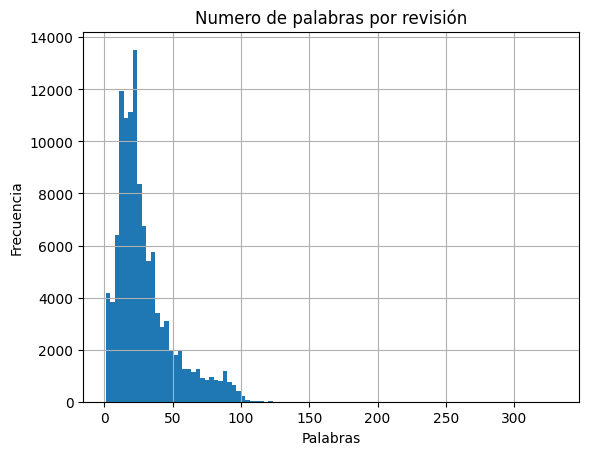

In [180]:
#cantidad de palabras por reseña o review
words_per_review = df.content.astype(str).apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por revisión')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

<Axes: xlabel='time'>

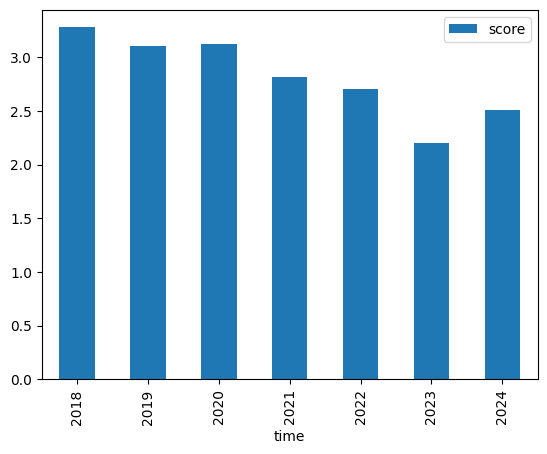

In [181]:
#promedio de scores por reseñas desde 2018 a 2024
df.groupby(df.time.dt.year)['score'].mean().to_frame().plot(kind="bar")

<Axes: xlabel='time'>

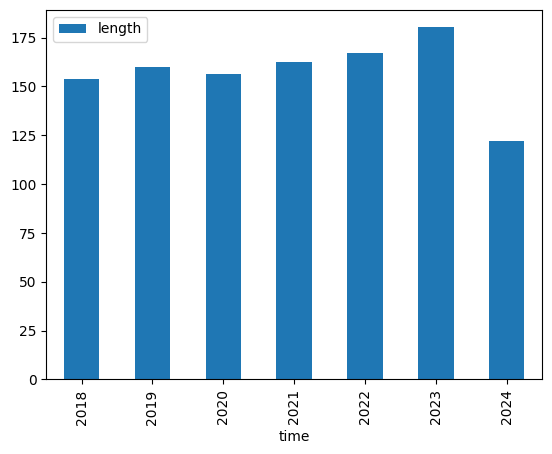

In [182]:
#promedio de largo de reseñas por año
df['length'] = df['content'].apply(lambda x: len(str(x)))
df.groupby(df.time.dt.year)['length'].mean().to_frame().plot(kind="bar")

In [183]:
#media de palabras por review
words_per_review.mean()

29.265046735418895

In [184]:
df.score.value_counts()

,count
score,
1,45516
5,33350
4,14043
3,12119
2,10944


Scores del 1 a 5

Text(0, 0.5, 'Porcentaje (%)')

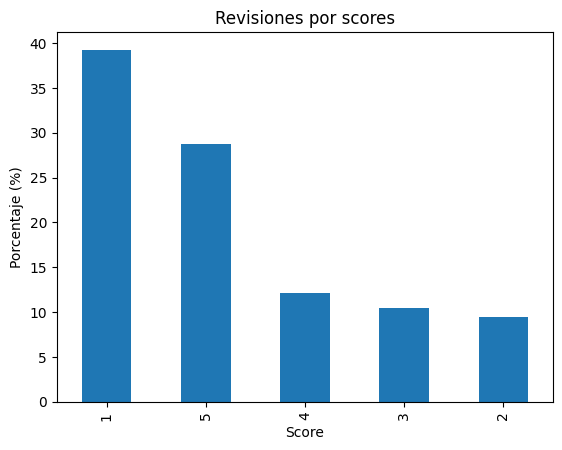

In [185]:
#representación del porcentaje de scores en el dataset
percent_val = 100 * df.score.value_counts()/df.shape[0]
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')


18082505


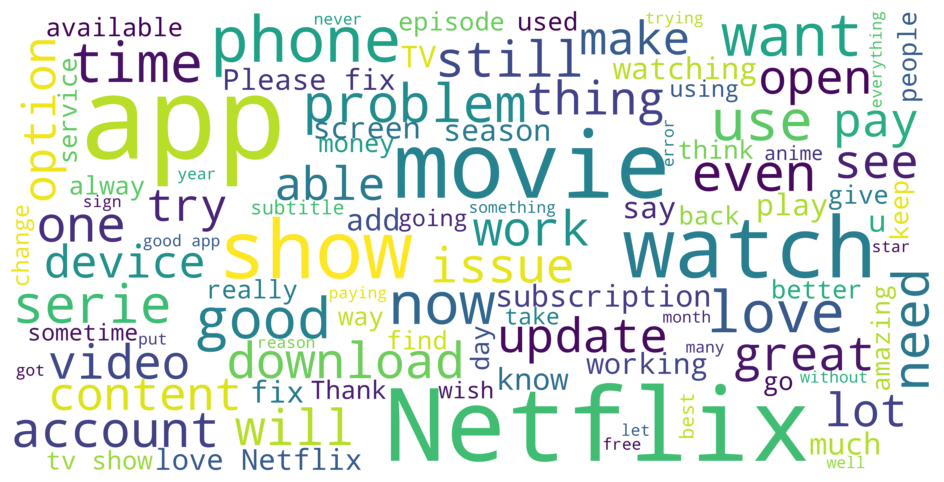

In [186]:
#generación de WordCloud text
from wordcloud import WordCloud

word_cloud_text = ''.join(df.content.astype(str))
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 5) Preprocesamiento

## 5.1) Estandarización de ratings

In [187]:
df1 = df.copy() #creo una copia del dataset df
df1['Sentiment_rating'] = np.where(df1.score > 3, 1, 0) #clasifico los scores según 1 (positivo) y 0 (negativo)
df1['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
0,68579
1,47393


Text(0, 0.5, 'Frecuencia')

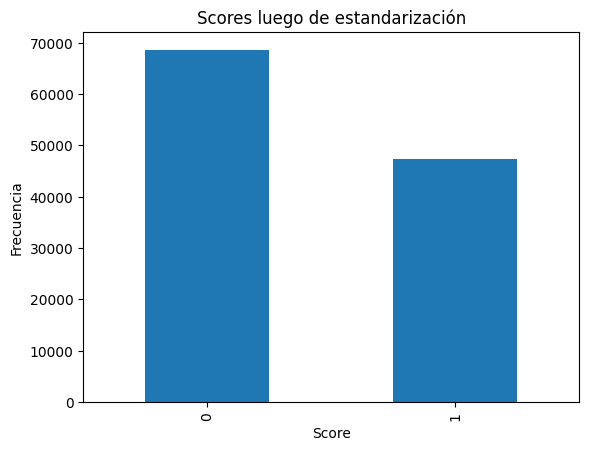

In [188]:
#gráfica de Scores estandarizados
df1.Sentiment_rating.value_counts().plot.bar()
plt.title('Scores luego de estandarización')
plt.xlabel('Score')
plt.ylabel('Frecuencia')

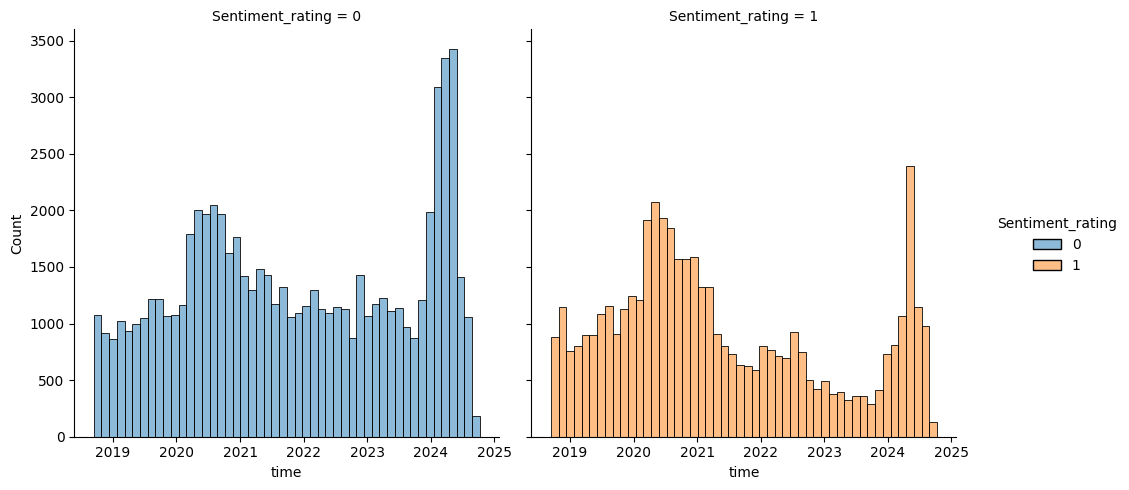

In [189]:
sns.displot(data=df1, x="time", hue="Sentiment_rating", col="Sentiment_rating") #evolución de Sentiment_rating en tiempo

## 5.2) Tokenización

In [190]:
df1['reviews_text_new'] = df1.content.astype(str).apply(lambda x: x.lower())

In [191]:
token_lists = [word_tokenize(each) for each in df1.content.astype(str)]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in df1.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

Numero de tokens unicos antes:  66449
Numero de tokens unicos nuevos:  54355


In [192]:
# Seleccionando los caracteres no alfa númericos que no son espacios
special_chars = df1.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'🕳', '🐆', 'ெ', '💍', '👶', '🥶', 'ಾ', '🥔', '🏢', '🏋', '✿', '“', '🧬', '◡', '🌸', '🍕', '🤭', '🎦', '🌞', '🔔', '🐎', '🇸', 'ো', '⛅', '🎏', '🌏', '🤬', '🇲', '🏕', '🛏', '◍', '👇', '\U0001fae4', '🐔', '🤞', '́', '💻', '🍋', '⌚', '×', '\u200a', '🕊', '😘', '😀', '⏰', '∆', '，', '☆', '☕', '🌱', '🧞', '🛑', '︻', '🍷', '🍄', '🍬', 'ो', '。', '😟', '🍗', '🌃', '😁', '⁉', '🥈', '🌽', '🧢', '🕸', '👓', 'ை', '🌗', '💒', '❄', '😍', 'ே', '😥', '😡', '－', '😦', '🏁', '؟', '😯', '્', '😞', '➖', '═', '̯', '♦', '🔅', '♡', '）', '🆓', '🏈', '،', '🏗', '💾', '¬', '🏠', 'ો', '&', '🔊', '😛', '🚽', '่', '💙', '⛽', '✈', '🔻', '■', '🐈', '⏳', 'ॉ', 'ि', '🌦', '🚴', '🚫', '️', '🏦', '🎉', '🏿', '😋', '？', '🌠', '⚽', '-', '🏰', 'ೈ', '÷', '¯', '🚣', '⚾', '🙈', '‼', '🎸', '💆', '👚', '🙁', '💮', '🐰', '(', '💌', '📫', '🏴', '😇', '💰', '🤚', 'ุ', '🕘', 'ೆ', '￣', '✍', '\u200d', '👧', '🐂', '👮', '্', '🍭', '🏝', '🎗', '┐', '🎁', '🅛', '🔸', '*', '🥞', '🍨', '🏳', '🎼', '⋆', '͡', '🍎', '🇵', '🧚', '🌰', ']', '🌷', '❣', '‸', '👘', '🧃', '🥕', '🧒', '💢', '😲', '😚', 'े', '🏆', '😤', '[', '¢', '😕', '🙅', '▽', '📺', '🔑', '\U0001faf

In [193]:
import re
review_backup = df1.reviews_text_new.copy()
df1.reviews_text_new = df1.reviews_text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

In [194]:
print("Review anterior:")
review_backup.values[11]

Review anterior:


"i sincerely don't like it that you forced me not to be able to use google pay to pay for my subscription for the first time but then afterwards won't allow me to upgrade my subscription to the premium.. the platform is high quality but the movies aren't.. netflix was pushing woke and feminist stuff long before most other companies but their biggest hits have all been male characters who aren't apart of the woke check list and while you're company still fails you still can't seem to figure it out"

In [195]:
print("Review nuevo:")
df1.reviews_text_new[11]

Review nuevo:


'i sincerely don t like it that you forced me not to be able to use google pay to pay for my subscription for the first time but then afterwards won t allow me to upgrade my subscription to the premium  the platform is high quality but the movies aren t  netflix was pushing woke and feminist stuff long before most other companies but their biggest hits have all been male characters who aren t apart of the woke check list and while you re company still fails you still can t seem to figure it out'

## 5.3) Stopwords y palabras de alta/baja frecuencia

In [196]:
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))

179


In [197]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('.', 156532),
 ('the', 109155),
 ('I', 108959),
 ('to', 95257),
 ('and', 87883),
 ('it', 82397),
 (',', 73514),
 ('is', 58455),
 ('a', 50073),
 ('app', 47251)]

Text(0, 0.5, 'Frecuencia')

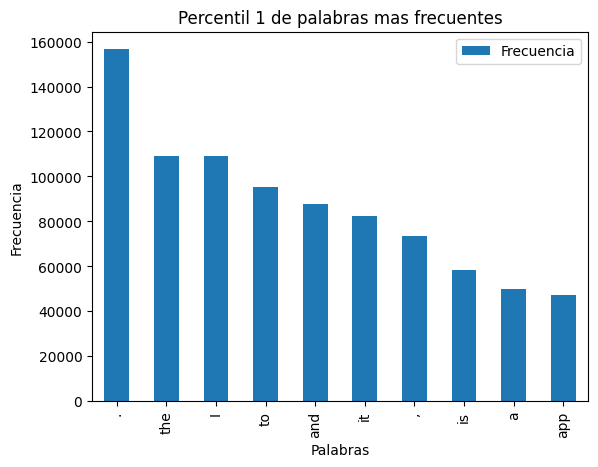

In [198]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [199]:
noise_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [200]:
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [201]:
#remoción de stop_words
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in eng_stop_words]
    return ' '.join(tokens)

# Aplico la función a la columna de reviews_text_new
df1['reviews_text_new2'] = df1['reviews_text_new'].apply(remove_stopwords)
df1.head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,appVersion,time,length,Sentiment_rating,reviews_text_new,reviews_text_new2
0,94c3dd9a-0ecb-4276-b62d-3d9de692ccac,Kmr Rahul,Supar,5,0,8.135.1 build 7 50902,8.135.1 build 7 50902,2024-10-09 14:45:35,5,1,supar,supar
1,a2de4715-77be-4d6a-89d2-66364c7a3576,K,I hate the new ads.,1,0,8.134.1 build 10 50872,8.134.1 build 10 50872,2024-10-09 14:44:59,19,0,i hate the new ads,hate new ads
2,2dc3dabe-ec6e-4a58-a23a-57fe0e2cb386,Lisa Salva,I'm noticing that I'm getting all the apps tha...,1,0,8.96.1 build 16 50568,8.96.1 build 16 50568,2024-10-09 14:36:33,228,0,i m noticing that i m getting all the apps tha...,noticing getting apps husband phone phone mean...
3,8f4c427f-bc4f-45e2-b248-648467742875,Keith,Was password sharing really the problem? Y'all...,1,0,,,2024-10-09 14:34:45,96,0,was password sharing really the problem y all...,password sharing really problem ruined app bad...
4,e081d547-a023-42cb-a341-480a69ffde7e,sumitra thapa,It is didn't sign up never use it Netflix 🤦😾,1,0,8.135.1 build 7 50902,8.135.1 build 7 50902,2024-10-09 14:31:32,44,0,it is didn t sign up never use it netflix,sign never use netflix


In [202]:
average_length = df1['reviews_text_new'].apply(len).mean()
average_length2 = df1['reviews_text_new2'].apply(len).mean()
print(f"El promedio del largo de las reseñas es: {average_length}")
print(f"El promedio del largo de las reseñas luego de la remoción de stop_words es: {average_length2}")

El promedio del largo de las reseñas es: 155.06734384161695
El promedio del largo de las reseñas luego de la remoción de stop_words es: 97.4846428448246


In [203]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('💓😍', 1),
 ('Iwatch', 1),
 ('perticularly', 1),
 ('Holiwood', 1),
 ('onNetflix', 1),
 ('Hinduphobhic', 1),
 ('Abusing', 1),
 ('rituals', 1),
 ('kimg', 1),
 ('GHET', 1)]

In [204]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

## 5.4) Sentimental analysis

In [205]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

In [206]:
df1['Polarity Score']=df1["reviews_text_new2"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df1['Neutral Score']=df1["reviews_text_new2"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df1['Negative Score']=df1["reviews_text_new2"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df1['Positive Score']=df1["reviews_text_new2"].apply(lambda x:SIA.polarity_scores(x)['pos'])

df1['Sentiment']=''
df1.loc[df1['Polarity Score']>0,'Sentiment']='Positive'
df1.loc[df1['Polarity Score']==0,'Sentiment']='Neutral'
df1.loc[df1['Polarity Score']<0,'Sentiment']='Negative'

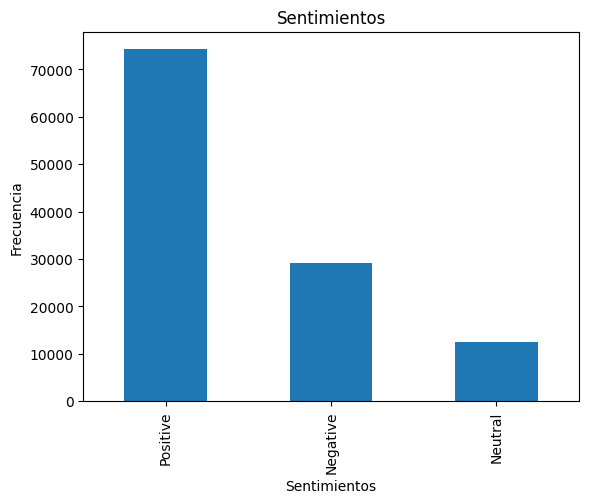

In [207]:
#frecuencia de Sentimientos en el dataset
df1['Sentiment'].value_counts().plot.bar()
plt.title('Sentimientos')
plt.xlabel('Sentimientos')
plt.ylabel('Frecuencia')
plt.show()

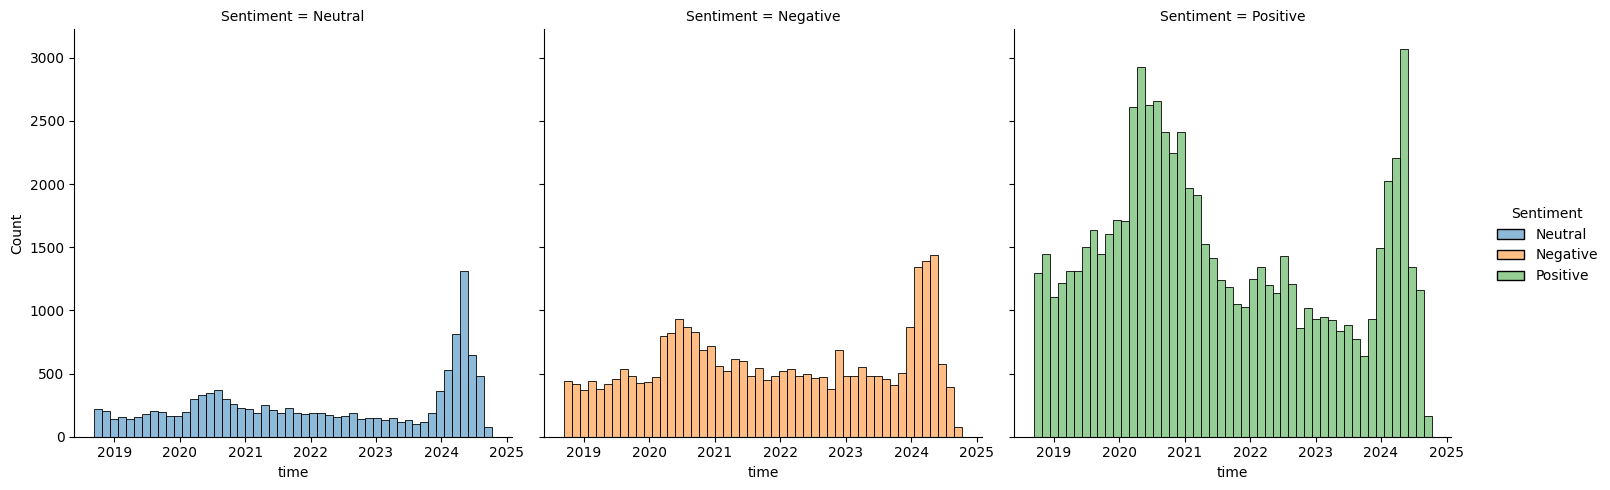

In [208]:
sns.displot(data=df1, x="time", hue="Sentiment", col="Sentiment") #evolución de los sentimientos en el tiempo

# 6) Modelado en ML

## 6.0) Bag of words

In [209]:
df1=df1[['reviews_text_new','score','Sentiment_rating']] #redefino mi dataset con solo las columnas relevantes para el modelado

In [210]:
# Creación de método para stemming

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [211]:
# Creación de un objeto tipo CountVectorizer
custom_tokenizer = stemmed_words
# Creación de un objeto tipo CountVectorizer
custom_tokenizer = stemmed_words
bow_counts = CountVectorizer(
    tokenizer=custom_tokenizer,
    token_pattern=None,
    stop_words= noise_words,
    ngram_range=(1, 4),
    max_features=10000
)

In [212]:
reviews_train, reviews_test = train_test_split(df1, test_size=0.2, random_state=0) #datos de testeo y entrenamiento

In [213]:
X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new) #transformación de mis datos de testeo y entrenamientos con BOW
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

In [214]:
y_train_bow = reviews_train['Sentiment_rating'] #etiquetas de los datos de entrenamiento
y_test_bow = reviews_test['Sentiment_rating'] #etiquetas de los datos de testeo

In [215]:
y_test_bow.value_counts() / y_test_bow.shape[0] #proporción de sentimientos en testeo

,count
Sentiment_rating,
0,0.588273
1,0.411727


In [216]:
y_train_bow.value_counts() / y_train_bow.shape[0] #proporción de sentimientos en entrenamiento

,count
Sentiment_rating,
0,0.592108
1,0.407892


## 6.1) Regresión logística

In [217]:
# Entreno el modelo
LR = LogisticRegression(C=0.5, solver="liblinear",penalty="l2")
LR.fit(X_train_bow, y_train_bow)

# Predigo el output
test_pred_lr_prob = LR.predict_proba(X_test_bow)
test_pred_lr_all = LR.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.7577985505724188
Accuracy:  80.11640439749947


In [218]:
#peso de las características en LR
LR_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names_out(),
        LR.coef_[0])
    ),
    columns=['words','weights']
)

LR_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
544,amaz,2.217860
3024,excel,2.101969
1082,awesom,2.043689
3361,four becaus,1.784594
155,4star,1.740806
5915,onli issu,1.704471
1166,beat,1.702393
8173,superb,1.669996
1479,brilliant,1.631220
3182,fantast,1.616257


In [219]:
LR_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
11,1001,-1.653922
7085,ridicul,-1.671611
9703,wast,-1.686681
4001,horribl,-1.706488
2591,downhil,-1.750081
9937,wrost,-1.792626
6103,pathet,-1.793929
1499,bs,-1.796189
9920,wors,-1.884961
8826,trash,-1.903232


In [220]:
test_pred_lr_prob

array([[0.39045869, 0.60954131],
       [0.92408986, 0.07591014],
       [0.55043727, 0.44956273],
       ...,
       [0.46462778, 0.53537222],
       [0.11801409, 0.88198591],
       [0.60386109, 0.39613891]])

In [221]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [222]:
predictions = pd.DataFrame()
predictions['reviews_text_new'] = reviews_test['reviews_text_new']
predictions['score'] = reviews_test['score']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities
predictions.head(10)

,reviews_text_new,score,Sentiment_rating,Predicted_sentiment,Predicted_probability
62912,they should have put as many tv series as poss...,5,1,1,0.609541
99045,i tried signing in and i putted my number and ...,1,0,0,0.075910
113208,my screen blacked out when trying to watch wi...,2,0,0,0.449563
26780,charged more than once on many occasions for m...,1,0,0,0.001637
64035,why does it not allows you to watch a season a...,3,0,0,0.293333
39537,i love that l can watch netflix on my mobile p...,5,1,1,0.748291
41835,my only issue with this app is that most thing...,4,1,1,0.901861
105201,love the shows on netflix especially the foren...,4,1,1,0.668674
91076,i hope nextflix make some improvement to the g...,5,1,1,0.891123
12784,interface is a mess it s so hard to scan tv s...,1,0,0,0.105103


In [223]:
predictions.loc[91076].values

array(['i hope nextflix make some improvement to the great future of company which mean add many more entertainer such as movie drama and live to this nextflix',
       5, 1, 1, 0.8911232001157826], dtype=object)

## 6.2) Random Forest

In [224]:
RF = RandomForestClassifier(n_estimators=150, max_depth=12)

# Entrenamiento
RF.fit(X_train_bow, y_train_bow)

# predicciones
test_pred_lr_prob = RF.predict_proba(X_test_bow)
test_pred_lr_all = RF.predict(X_test_bow)

In [225]:
print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.1600153491941673
Accuracy:  62.25048501832291


In [226]:
feature_importances = pd.DataFrame(
    RF.feature_importances_,
    index=bow_counts.get_feature_names_out(),
    columns=['importance']
)
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
movi,0.044716
amaz,0.042561
awesom,0.040078
tri,0.030457
updat,0.024215
subscript,0.020555
devic,0.020218
seri,0.019733
whi,0.017601
cannot,0.016705


#7) Conclusiones

En este caso, se analizó y procesó un conjunto de datos de reseñas de Netflix. Se estudiaron dos modelos de clasificación para predecir el sentimiento. Para la técnica de procesamiento, bag of words, se obtuvo una mejor precisión con LogisticRegression, del 80%, mientras que RF se comportó peor. Se pudo observar que al aumentar el conjunto de n-gramas, la precisión del modelo no mejoró.